In [10]:
import pandas as pd
import pvlib
from pvlib.location import Location
import matplotlib.pyplot as plt
import numpy as np
from sympy import*
from scipy.optimize import curve_fit
from scipy import integrate # indlæses også senere i selve opgaven

In [ ]:
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "H"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 23:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)


### Ny kode

In [12]:
theta_sol = np.deg2rad(solpos.loc["2024-04-20"].zenith.values)
phi_sol = np.deg2rad(solpos.loc["2024-04-20"].azimuth.values)

In [28]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    nLB = 0.185*1.63 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.stack([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ], axis=-1)

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])
    dot_products = nLB * np.sum(u_s * u_p, axis=-1)
    return np.maximum(dot_products, 0)

In [29]:
flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

In [30]:
from scipy import integrate

energi = integrate.simpson(flux_array, dx=60)  # i [W·s] eller Joule

In [31]:
energi_Wh = energi / 3600
energi_Wh

1.4899159141520846

In [ ]:
phi_panel = np.deg2rad(180)
energier = []
wh_energier = []

for vinkel in range(0, 90):  # 0° til 90°
    theta_panel = np.deg2rad(vinkel)
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
    energi = integrate.simpson(flux_array, dx=3600)
    energier.append(energi)
    wh_energier.append(energi/3600)


energier # i enheden Joule pr sekunder
wh_energier # i enheden kWh 

[1.945269744740681,
 1.9672226744095207,
 1.9887339219509461,
 2.009786592149519,
 2.030368530924662,
 2.050458326780958,
 2.0700424143550267,
 2.0891079202018115,
 2.107642215548396,
 2.125632926250459,
 2.1430679426689725,
 2.159941589157176,
 2.1762446646031397,
 2.191960232170053,
 2.20708548742654,
 2.221604458433866,
 2.235525251650154,
 2.2488264885736244,
 2.2615039552446428,
 2.2735556072793304,
 2.2849729717256295,
 2.29574497682941,
 2.305879872069957,
 2.3153598577214876,
 2.3241817798316657,
 2.3323506146157627,
 2.339849374515193,
 2.346687484070725,
 2.352847937825861,
 2.35834128273135,
 2.3631521350062363,
 2.3672897716393617,
 2.3707404071257825,
 2.3735130545816094,
 2.3755955281465866,
 2.3769972879017085,
 2.3777059214010197,
 2.3777312156903907,
 2.3770619789471867,
 2.37570779979359,
 2.373658685184238,
 2.3709240223117733,
 2.3674961182107017,
 2.3633830200770896,
 2.3585817067415586,
 2.3530929134346397,
 2.3469217874330695,
 2.340062474206468,
 2.3325236323468

ValueError: x and y must have same first dimension, but have shapes (24,) and (1440,)

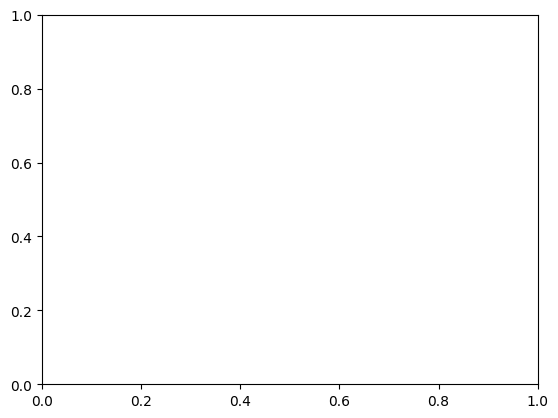

In [54]:
time_index = solpos.loc["2024-04-20"].index
time_array = np.array([t.hour + t.minute/60 for t in time_index])

flux = solar_panel_projection(theta_sol, phi_sol, np.deg2rad(30), np.deg2rad(180))
plt.plot(time_array, flux)
plt.xlabel("Tid (timer)")
plt.ylabel("Flux")
plt.title("Flux på solpanel den 20. april 2024")
plt.grid()
plt.show()

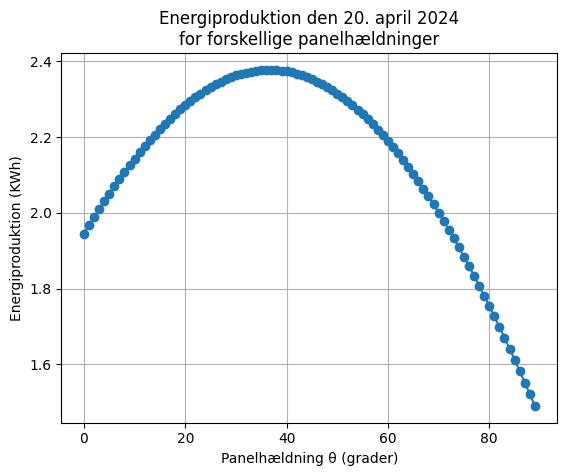

37

In [37]:
hældninger = np.arange(0, 90)  # 0° til 90°
plt.plot(hældninger, wh_energier, marker='o')
plt.xlabel("Panelhældning θ (grader)")
plt.ylabel("Energiproduktion (KWh)")
plt.title("Energiproduktion den 20. april 2024\nfor forskellige panelhældninger")
plt.grid(True)
plt.show()
np.argmax(wh_energier)

In [64]:
# henter pris data
import requests
import pandas as pd

endpoint = "https://api.energidataservice.dk/dataset/elspotprices"
params = {
    "start": "2024-01-01T00:00",
    "end": "2024-12-31T23:00",
    "filter": '{"PriceArea":["DK2"]}'  # <-- fixed JSON string
}

response = requests.get(endpoint, params=params)
data = response.json()
df = pd.DataFrame(data['records'])
# Konverter evt. enheder (øre/kroner, kWh/J/MJ) hvis nødvendigt.
# følgende er forkert, dvs. tidsrumer ganget med forskudte.
print(df)
energi = integrate.simpson(flux_array, dx=3600)
energi

                  HourUTC               HourDK PriceArea  SpotPriceDKK  \
0     2024-12-31T21:00:00  2024-12-31T22:00:00       DK2     59.529999   
1     2024-12-31T20:00:00  2024-12-31T21:00:00       DK2    117.120003   
2     2024-12-31T19:00:00  2024-12-31T20:00:00       DK2    168.509995   
3     2024-12-31T18:00:00  2024-12-31T19:00:00       DK2    180.820007   
4     2024-12-31T17:00:00  2024-12-31T18:00:00       DK2    193.729996   
...                   ...                  ...       ...           ...   
8778  2024-01-01T03:00:00  2024-01-01T04:00:00       DK2    178.990005   
8779  2024-01-01T02:00:00  2024-01-01T03:00:00       DK2    182.490005   
8780  2024-01-01T01:00:00  2024-01-01T02:00:00       DK2    198.740005   
8781  2024-01-01T00:00:00  2024-01-01T01:00:00       DK2    212.160004   
8782  2023-12-31T23:00:00  2024-01-01T00:00:00       DK2    217.160004   

      SpotPriceEUR  
0         7.980000  
1        15.700000  
2        22.590000  
3        24.240000  
4     

321821.8374568503

In [109]:
# nyt solpos object, der paser til mængden fra tidligere, men med gennemsnit over timer, og mangler sidste time af 12-31, 
tidszone = "Europe/Copenhagen"
start_dato = "2024-01-01"
slut_dato = "2024-12-31"
delta_tid = "h"  # "Min", "H",

# Definition of Location object. Coordinates and elevation of Amager, Copenhagen (Denmark)
site = Location(
    55.47092, 12.31168, tidszone, 10, "Danmarks Tekniske Universitet (DK)"
)  # latitude, longitude, time_zone, altitude, name

# Højde er ca 50 m MOH

# Definition of a time range of simulation
times = pd.date_range(
    start_dato + " 00:00:00", slut_dato + " 22:59:59", inclusive="left", freq=delta_tid, tz=tidszone
)

# Estimate Solar Position with the 'Location' object
solpos = site.get_solarposition(times)

solpos.zenith.shape

times.shape, 364*24-1




((8783,), 8735)

In [100]:
def solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel):
    theta_sol = np.asarray(theta_sol)
    phi_sol = np.asarray(phi_sol)
    nLB = 0.185*1.63 # n er overførelsen, altså hvor meget energi fra solen er arbejdsom, målt fra når den rammer pannelet til den kommer ind i et andet kredsløb
    u_s = np.array([
        np.sin(theta_sol) * np.cos(phi_sol),
        np.sin(theta_sol) * np.sin(phi_sol),
        np.cos(theta_sol)
    ])

    u_p = np.array([
        np.sin(theta_panel) * np.cos(phi_panel),
        np.sin(theta_panel) * np.sin(phi_panel),
        np.cos(theta_panel)
    ])

    dot_products = nLB * u_s.T@u_p
    return np.maximum(dot_products, 0)

# solar_panel_projection(np.array([1,2,3]), np.array([1,3,3]), np.array([1]), np.array([1]))

In [ ]:
# Flux array constructor
for zenitha in range(0, 91):  # 0° til 90°
    theta_panel = np.deg2rad(zenitha)
    phi_panel = np.deg2rad(1)
    for azimutha in range(0, 361):
        flux_array
    flux_array = np.where(
        theta_sol <= np.pi / 2,
        solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
        0.0)
theta_panel, phi_panel = np.deg2rad(50), np.deg2rad(180)
theta_sol, phi_sol = np.deg2rad(solpos.zenith.values), np.deg2rad(solpos.azimuth.values)

energier = []
wh_energier = []

flux_array = np.where(
    theta_sol <= np.pi / 2,
    solar_panel_projection(theta_sol, phi_sol, theta_panel, phi_panel),
    0.0)

print(flux_array[18:1000])
energi = integrate.simpson(flux_array, dx=3600)
print(energi)
energier.append(energi)
wh_energier.append(energi/3600)

print(energier)


[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17152494 0.21897085 0.25074213
 0.26467397 0.25981655 0.23649982 0.1963111  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17126746 0.21885627 0.25078118
 0.26486684 0.26015287 0.2369594  0.19686526 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17102712 0.21875994 0.25083859
 0.26507715 0.26050477 0.23743184 0.19742894 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.17080414 0.21868195 0.25091429
 0.2653047  0.26087189 0.23791668 0.19800159 0.         0.
 0.         0.         0

In [114]:
theta_sol.shape

(8783,)

In [116]:
len(energier)

97

In [102]:
print(theta_sol.shape)

(8783,)


In [87]:
theta_sol = np.deg2rad(solpos.zenith.values)
len(energier)
60*365-1

21899